#Capstone project Ayiti Analytics 


##By Fritz Gerald Junior Valcin

#Install needed Packages

In [ ]:
#Install needed package
!pip install git+https://github.com/statsmodels/statsmodels.git
!python -m pip install git+https://github.com/statsmodels/statsmodels
!pip install geopandas
!pip install statsmodels
!pip install mapclassify
!pip install pillow
!pip install opencv-python
!pip install path.py
!pip install bar-chart-race


# Objective
###What is the objective or goal that you are trying to accomplish? What is the decision that you must make?

I want to show the evolution of the local and imported price of food over the years, search which variable has an on the local marmite rice and predict the price of local.

# Hypothesis: Research Question?
 What is the question that you would like to answer in order to make a decision?
 See which variable we should control to control the price of local marmite rice

 What variable has an significant impact on the price of the food ?
 The exchange rate and the evolution of the price of petrol has an impact on the price of food

# Import librairies

In [ ]:
#####
# import librairies
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
# import fiona
import io
import re
import datetime
from datetime import datetime

from statsmodels.tsa.api import ARDL 
from statsmodels.datasets import danish_data 
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
import statsmodels.stats as sm_stat
import statsmodels.stats as smt
import scipy.optimize as optimize
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle

# geopandas for geodataviz
import geopandas as gpd
from geopy.geocoders import Nominatim 
import folium
import PIL
from IPython.display import Image
import cv2
import os
from os.path import isfile, join
# import folium as f

# from sklearn.linear_model import LinearRegression as linear_reg
from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler



#Open dataset

In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

  #Open the dataset in python
foodPrice = pd.read_csv('/content/drive/MyDrive/Capston_Project_Ayiti_Analytics/wfp_food_prices_hti (1).csv')
prix_petrol = pd.read_excel('/content/drive/MyDrive/Capston_Project_Ayiti_Analytics/Weekly-GAS-PRICES.xlsx')
exchange_rate = pd.read_csv('/content/drive/MyDrive/Capston_Project_Ayiti_Analytics/HTG=X.csv')
gpd_com = gpd.read_file('/content/drive/MyDrive/Capston_Project_Ayiti_Analytics/boundaries/hti_admbnda_adm2_cnigs_20181129.shp')
gpd_dep = gpd.read_file('/content/drive/MyDrive/Capston_Project_Ayiti_Analytics/boundaries/hti_admbnda_adm1_cnigs_20181129.shp')


#Processing of the exchange rate data

In [ ]:
exchange_rate.head()

Date       Open       High        Low      Close  Adj Close  Volume
0  2005-11-01  40.500000  40.637001  39.976002  40.450001  40.450001       0
1  2005-12-01  40.442001  40.603001  40.215000  40.491001  40.491001       0
2  2006-01-01  40.452999  42.798000  40.283001  41.945000  41.945000       0
3  2006-02-01  42.000000  42.053001  39.987000  40.206001  40.206001       0
4  2006-03-01  40.224998  40.484001  39.661999  39.998001  39.998001       0

In [ ]:
#change the format of date
exchange_rate['Date']=pd.to_datetime(exchange_rate['Date']).map(lambda x: x.strftime('%d-%m-%Y'))
exchange_rate['Date'] = exchange_rate['Date'].map(lambda x: "15"+x[2:])
exchange_rate= exchange_rate.rename(columns={'Date':'date','Close':'Taux de change'})
exchange_rate.drop(['Open','High','Low','Adj Close','Volume'],axis=1, inplace=True)
# exchange_rate.set_index('date',inplace=True)


In [ ]:
exchange_rate.head()

date  Taux de change
0  15-11-2005       40.450001
1  15-12-2005       40.491001
2  15-01-2006       41.945000
3  15-02-2006       40.206001
4  15-03-2006       39.998001

#End of the processing of the exchange rate data

#Preprocessing of petrol price

In [ ]:
petrol = prix_petrol.copy()

In [ ]:
petrol.head()

Indicator  ... 2018W32
0          KN.A2  ...     NaN
1          KN.A4  ...    0.88
2            NaN  ...     NaN
3        Source:  ...     NaN
4  Download URL:  ...     NaN

[5 rows x 189 columns]

In [ ]:
# Drop the unused columns and rows and rename columns
cols=['Indicator','Indicator Name','Country','Country Name','Country notes','Country RegionId','Measure','Measure Name','Scale','Units']
petrol.drop(cols, axis=1, inplace=True)
petrol.drop(petrol.index[2:], axis=0, inplace=True)
petrol = petrol.transpose()
petrol = petrol.reset_index()
petrol.rename(columns={"index":"date",0:"Diesel_Unit_Liter_USD",1:"Gasoline_Unit_Liter_USD"}, inplace=True)
# # petrol.columns = [''] * len(petrol.columns)

In [ ]:
list_ = petrol.iloc[[0],:]
print(list_)

      date  Diesel_Unit_Liter_USD  Gasoline_Unit_Liter_USD
0  2016W13                   0.67                     0.88


In [ ]:
#petrol dateframe
petrol.head()

date  Diesel_Unit_Liter_USD  Gasoline_Unit_Liter_USD
0  2016W13                   0.67                     0.88
1  2016W14                   0.69                     0.87
2  2016W15                   0.64                     0.81
3  2016W16                   0.64                     0.81
4  2016W17                   0.65                     0.82

In [ ]:
#show the mean of petrol price per month
def getMonth(x):
  x = int(x)
  return int(x * 0.2299) + 1


dico = {}
dicoGasol = {}
for row in petrol.index:
  date  = petrol['date'][row]
  diesel = petrol['Diesel_Unit_Liter_USD'][row]
  gasoline = petrol['Gasoline_Unit_Liter_USD'][row]
  index = date.find('W')
  if index != -1:
    annee = date[:index]
    mois = getMonth(date[index+1:])
    key = '15-'+str(mois)+'-'+str(annee)
    prev = dico.get(key,0)
    prevGasol = dicoGasol.get(key,0)
    if prev == 0:

      dico[key] = diesel
    else:
      dico[key] = (diesel + prev)/2

    if prevGasol == 0:
      dicoGasol[key] = gasoline
    else:
      dicoGasol[key] = (gasoline+prevGasol)/2

dieselDF = pd.DataFrame(dico.items())
gasolDF = pd.DataFrame(dicoGasol.items())
display(dieselDF.head(2))
display(gasolDF.head(2))
# gasolDF.head()
     

0        1
0  15-3-2016  0.67000
1  15-4-2016  0.65125

0       1
0  15-3-2016  0.8800
1  15-4-2016  0.8225

In [ ]:
#Rename columns of Diesel dataframe
gasolDF.reset_index(inplace=True)
cols = {0:'date',1:'Gasoline_Unit_Liter_USD'}
gasolDF.rename(columns=cols, inplace=True)
gasolDF.reset_index(inplace=True)
gasolDF.drop(['level_0','index'], axis=1, inplace=True)
gasolDF.head()

date  Gasoline_Unit_Liter_USD
0   15-3-2016                  0.88000
1   15-4-2016                  0.82250
2   15-5-2016                  0.80125
3   15-9-2016                  0.75000
4  15-10-2016                  0.74375

In [ ]:
#Rename columns of Diesel dataframe
dieselDF.reset_index(inplace=True)
cols = {0:'date',1:'Diesel_Unit_Liter_USD'}
dieselDF.rename(columns=cols, inplace=True)
dieselDF.reset_index(inplace=True)
dieselDF.drop(['level_0','index'], axis=1, inplace=True)
dieselDF.head()

date  Diesel_Unit_Liter_USD
0   15-3-2016                0.67000
1   15-4-2016                0.65125
2   15-5-2016                0.62750
3   15-9-2016                0.59000
4  15-10-2016                0.59000

In [ ]:
#merge the two dataframe
petrolGD = pd.merge(dieselDF, gasolDF, on='date', how='inner')


In [ ]:
petrolGD.head()

date  Diesel_Unit_Liter_USD  Gasoline_Unit_Liter_USD
0   15-3-2016                0.67000                  0.88000
1   15-4-2016                0.65125                  0.82250
2   15-5-2016                0.62750                  0.80125
3   15-9-2016                0.59000                  0.75000
4  15-10-2016                0.59000                  0.74375

#End of preprocessing of petrol price

#Preprocessing food data

In [ ]:
# Make a copy of the dataframes
food = foodPrice.copy()

In [ ]:
#Read the dataframe
food.head()

date      admin1      admin2  ...   currency   price    usdprice
0       #date  #adm1+name  #adm2+name  ...  #currency  #value  #value+usd
1  2005-01-15  Artibonite    Gonaives  ...        HTG    60.0        0.61
2  2005-01-15  Artibonite    Gonaives  ...        HTG    94.0        0.96
3  2005-01-15  Artibonite    Gonaives  ...        HTG    60.0        0.61
4  2005-01-15      Centre      Hinche  ...        HTG   13.16        0.13

[5 rows x 13 columns]

In [ ]:
#Drop the first row and drop unnecessary columns
food.drop(index=0,axis=0,inplace=True)
food.reset_index(inplace=True)
food.drop(columns=['index','currency','pricetype'],inplace=True)


Rename columns

In [ ]:
dict = {'admin1':'departement',
        'admin2':'commune',
        'price':'gdesPrice',
        'usdprice':'usdPrice'}
food.rename(columns=dict, inplace=True)


Change some type error

In [ ]:
#Change type of these columns
food['date']=pd.to_datetime(food['date']).map(lambda x: x.strftime('%d-%m-%Y'))
food = food.astype({'latitude':'float64','longitude':'float64','gdesPrice':'float64','usdPrice':'float64'})

Look for abnormal values

In [ ]:
food.describe()

latitude     longitude     gdesPrice      usdPrice
count  12864.000000  12864.000000  12864.000000  12864.000000
mean      18.949271    -72.696506    151.046181      1.542695
std        0.611401      0.753649    159.498471      1.629068
min       18.200000    -74.083333      6.750000      0.070000
25%       18.234167    -72.831900     33.330000      0.340000
50%       18.616667    -72.534722     90.000000      0.920000
75%       19.550000    -72.204167    214.250000      2.192500
max       19.939051    -71.733333    937.500000      9.570000

In [ ]:
food.describe(include='O')

date departement  ...               commodity     unit
count        12864       12864  ...                   12864    12864
unique         197           9  ...                      12        4
top     15-09-2017  South-East  ...  Wheat flour (imported)  Marmite
freq            95        1784  ...                    1698     7257

[4 rows x 7 columns]

In [ ]:
food.head()

date departement   commune  ...     unit  gdesPrice  usdPrice
0  15-01-2005  Artibonite  Gonaives  ...  Marmite      60.00      0.61
1  15-01-2005  Artibonite  Gonaives  ...  Marmite      94.00      0.96
2  15-01-2005  Artibonite  Gonaives  ...  Marmite      60.00      0.61
3  15-01-2005      Centre    Hinche  ...    Pound      13.16      0.13
4  15-01-2005      Centre    Hinche  ...  Marmite      36.00      0.37

[5 rows x 11 columns]

In [ ]:
#Create a new column to show imported and local products
food = food.assign(origin = 'imported')
for item in ['local','imported']:
  food['origin'][food['commodity'].str.contains(item)] = item
food['commodity'] = food['commodity'].str.replace(r"\(.*\)","")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
food.head()

date departement   commune  ... gdesPrice  usdPrice    origin
0  15-01-2005  Artibonite  Gonaives  ...     60.00      0.61     local
1  15-01-2005  Artibonite  Gonaives  ...     94.00      0.96  imported
2  15-01-2005  Artibonite  Gonaives  ...     60.00      0.61  imported
3  15-01-2005      Centre    Hinche  ...     13.16      0.13  imported
4  15-01-2005      Centre    Hinche  ...     36.00      0.37     local

[5 rows x 12 columns]

#End of food data preprocessing


#1-Search for the trend of prices over the year

#Food

# Analysis of price food per year and per month

##Local food Vs Imported food



*   Product X product analysis

*  Analysis local product price X imported product price

*   Analysis category X category

*   Price evolution by category

*   Price analysis in gourdes X price in USD

*   Price variations by department over the last 15 years

*   Test

*   ARDL model


In [ ]:
food.head()

date departement   commune  ... gdesPrice  usdPrice    origin
0  15-01-2005  Artibonite  Gonaives  ...     60.00      0.61     local
1  15-01-2005  Artibonite  Gonaives  ...     94.00      0.96  imported
2  15-01-2005  Artibonite  Gonaives  ...     60.00      0.61  imported
3  15-01-2005      Centre    Hinche  ...     13.16      0.13  imported
4  15-01-2005      Centre    Hinche  ...     36.00      0.37     local

[5 rows x 12 columns]

In [ ]:
#find the local and imported product
filtering = food['origin'] == "local"
local_food = food.where(filtering).dropna()
filtering = food['origin'] == "imported"
imported_food = food.where(filtering).dropna()
#local product
local_product = local_food.groupby(by=['commodity']).size().to_frame()
local_product.columns = ['Total local product']


In [ ]:
#Imported product
imported_product = imported_food.groupby(by=['commodity']).size().to_frame()
imported_product.columns = ['Total imported product']

In [ ]:
imported_product.head()

Total imported product
commodity                          
Beans                          2460
Maize meal                     1127
Oil                             870
Pasta                           492
Rice                           1563

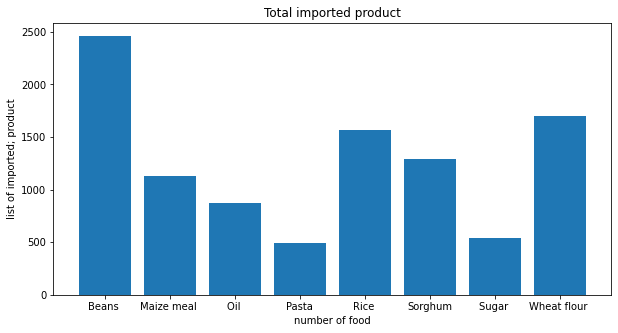

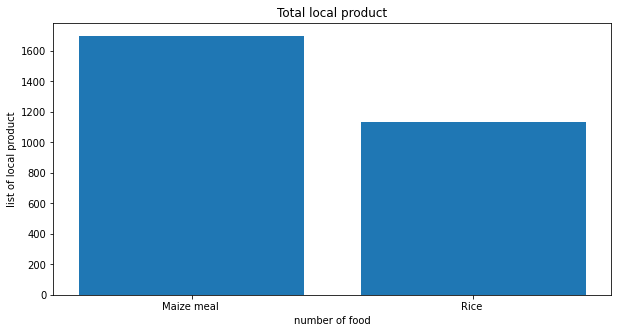

In [ ]:
#Show the total of local product
plt.figure(figsize=(10,5))
plt.bar(imported_product.index,imported_product['Total imported product'])
plt.title('Total imported product')
plt.xlabel('number of food')
plt.ylabel('list of imported; product')
plt.show()
plt.figure(figsize=(10,5))
plt.bar(local_product.index,local_product['Total local product'])
plt.title('Total local product')
plt.xlabel('number of food')
plt.ylabel('list of local product')
plt.show()



#Product X product analysis

In [ ]:
foods_p = pd.pivot_table(data=food[food.unit=='Marmite'],index=["date",'departement','commune','origin'],columns=["commodity"],values='gdesPrice',aggfunc="mean")

In [ ]:
foods_p

commodity                                       Beans   ...  Wheat flour 
date       departement commune        origin            ...              
15-01-2005 Artibonite  Gonaives       imported     NaN  ...          60.0
                                      local        NaN  ...           NaN
           Centre      Hinche         imported     NaN  ...          53.4
                                      local        NaN  ...           NaN
           Grande'Anse Jeremie        imported     NaN  ...          72.0
...                                                ...  ...           ...
15-12-2020 South       Les Cayes      local        NaN  ...           NaN
           South-East  Jacmel         imported   549.0  ...         162.0
                                      local        NaN  ...           NaN
           West        Port-au-Prince imported   600.0  ...         165.0
                                      local        NaN  ...           NaN

[3399 rows x 6 columns]

##Analysis the local food

In [ ]:
food.head()

date departement   commune  ... gdesPrice  usdPrice    origin
0  15-01-2005  Artibonite  Gonaives  ...     60.00      0.61     local
1  15-01-2005  Artibonite  Gonaives  ...     94.00      0.96  imported
2  15-01-2005  Artibonite  Gonaives  ...     60.00      0.61  imported
3  15-01-2005      Centre    Hinche  ...     13.16      0.13  imported
4  15-01-2005      Centre    Hinche  ...     36.00      0.37     local

[5 rows x 12 columns]

In [ ]:
#Create new columns to fasilitate our analysis and turning them from string to integer
food['month'] = food['date'].str[3:5]
food['year'] = food['date'].str[6:]
# food.astype({'month':'int64',' year':'int64'})
food.set_index('date', inplace=True)

In [ ]:
#Search the local food on the dataset
filtering = food['origin'] == "local"
local_food = food.where(filtering).dropna().astype({'month':'int64','year':'int64'})
local_food.reset_index(inplace=True)
pd.to_datetime(local_food.date)
local_food.head()


date  departement   commune    market  ...  usdPrice  origin month  year
0  15-01-2005   Artibonite  Gonaives  Gonaives  ...      0.61   local     1  2005
1  15-01-2005       Centre    Hinche    Hinche  ...      0.37   local     1  2005
2  15-01-2005       Centre    Hinche    Hinche  ...      0.25   local     1  2005
3  15-01-2005  Grande'Anse   Jeremie   Jeremie  ...      0.24   local     1  2005
4  15-01-2005  Grande'Anse   Jeremie   Jeremie  ...      0.31   local     1  2005

[5 rows x 14 columns]

In [ ]:
local_food.unit.unique()

array(['Marmite', 'Pound'], dtype=object)

##Local Maize meal

###Marmite

In [ ]:
#Search marmite Maize meal in the local food
marmite_mais_local = local_food[(local_food['commodity']=='Maize meal ') & (local_food['unit']=='Marmite')]
marmite_mais_local.head()


# local_food.commodity = local_food.commodity.apply(lambda x: x.strip())

date  departement      commune  ... origin  month  year
0  15-01-2005   Artibonite     Gonaives  ...  local      1  2005
1  15-01-2005       Centre       Hinche  ...  local      1  2005
3  15-01-2005  Grande'Anse      Jeremie  ...  local      1  2005
5  15-01-2005        North  Cap-Haitien  ...  local      1  2005
7  15-01-2005   North-East  Ouanaminthe  ...  local      1  2005

[5 rows x 14 columns]

In [ ]:
# mean price of marmite Maize meal per year
mean_marmite_mais_local_per_year = marmite_mais_local.groupby(by=['commodity','year']).gdesPrice.mean().to_frame()
mean_marmite_mais_local_per_year.reset_index('commodity',inplace=True)
mean_marmite_mais_local_per_year.head()

commodity  gdesPrice
year                        
2005  Maize meal   49.932963
2006  Maize meal   59.877778
2007  Maize meal   50.879167
2008  Maize meal   86.886413
2009  Maize meal   76.747619

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


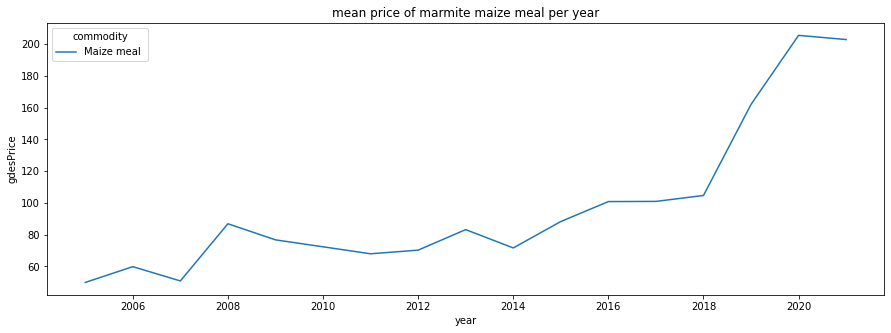

In [ ]:
#graph
def lineplot_co(df,title='mean price of marmite maize meal per year'):
  plt.figure(figsize=(15,5))
  plt.title(title)
  sns.lineplot(df.index, 'gdesPrice', ci=None, 
             hue='commodity', data=df.reset_index())
  

lineplot_co(mean_marmite_mais_local_per_year, title='mean price of marmite maize meal per year')

##Local Rice

###Marmite

In [ ]:
#Search marmite Rice in the local food
marmite_rice_local = local_food[(local_food['commodity']=='Rice ') & (local_food['unit']=='Marmite')]
marmite_rice_local.reset_index(inplace=True)
marmite_rice_local = marmite_rice_local.iloc[:,1:]
marmite_rice_local.head()


date departement       commune  ... origin  month  year
0  15-05-2014  Artibonite      Gonaives  ...  local      5  2014
1  15-05-2014      Centre        Hinche  ...  local      5  2014
2  15-05-2014       North   Cap-Haitien  ...  local      5  2014
3  15-05-2014  North-West  Port-de-Paix  ...  local      5  2014
4  15-05-2014       South     Les Cayes  ...  local      5  2014

[5 rows x 14 columns]

In [ ]:
# mean price of of local rice per year
mean_marmite_rice_local_per_year = marmite_rice_local.groupby(by=['commodity','year']).gdesPrice.mean().to_frame()
mean_marmite_rice_local_per_year.reset_index('commodity',inplace=True)
mean_marmite_rice_local_per_year.head()

commodity   gdesPrice
year                      
2014     Rice   142.634615
2015     Rice   153.071429
2016     Rice   153.622024
2017     Rice   166.374699
2018     Rice   225.549091

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


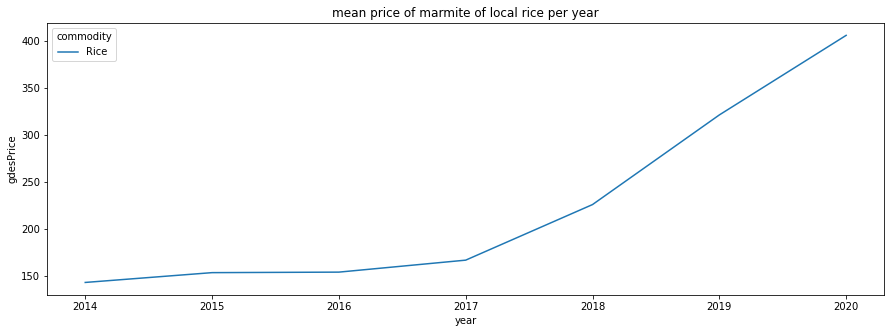

In [ ]:
# graph to show mean price of marmite of local rice per year
lineplot_co(mean_marmite_rice_local_per_year, title='mean price of marmite of local rice per year')

###Pound

In [ ]:
#Search pound Rice in the local food
pound_rice_local = local_food[(local_food['commodity']=='Rice ') & (local_food['unit']=='Pound')]
pound_rice_local.reset_index(inplace=True)
display(pound_rice_local.columns)
pound_rice_local = pound_rice_local.iloc[:,1:]
pound_rice_local.head()

Index(['index', 'date', 'departement', 'commune', 'market', 'latitude',
       'longitude', 'category', 'commodity', 'unit', 'gdesPrice', 'usdPrice',
       'origin', 'month', 'year'],
      dtype='object')

date  departement      commune  ... origin  month  year
0  15-01-2005       Centre       Hinche  ...  local      1  2005
1  15-01-2005  Grande'Anse      Jeremie  ...  local      1  2005
2  15-01-2005        North  Cap-Haitien  ...  local      1  2005
3  15-01-2005        South    Les Cayes  ...  local      1  2005
4  15-01-2005   South-East       Jacmel  ...  local      1  2005

[5 rows x 14 columns]

In [ ]:
# mean price of Maize meal pot per year
mean_pound_rice_local = pound_rice_local.groupby(by=['commodity','year']).gdesPrice.mean().to_frame()
mean_pound_rice_local.reset_index('commodity',inplace=True)
mean_pound_rice_local.head()

commodity  gdesPrice
year                     
2005     Rice   26.230909
2006     Rice   32.195000
2007     Rice   36.521667
2008     Rice   41.720455
2009     Rice   43.155000

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


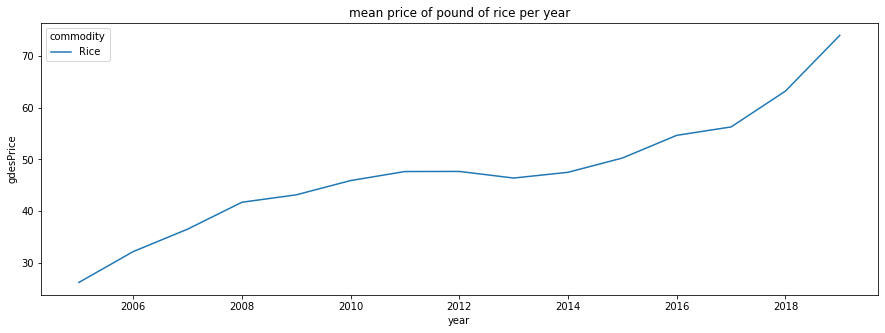

In [ ]:
# graph to show mean price of pound of rice per year
lineplot_co(mean_pound_rice_local, title='mean price of pound of rice per year')

##Analysis on imported food

In [ ]:
imported_food.head()

date departement   commune  ... gdesPrice  usdPrice    origin
1  15-01-2005  Artibonite  Gonaives  ...     94.00      0.96  imported
2  15-01-2005  Artibonite  Gonaives  ...     60.00      0.61  imported
3  15-01-2005      Centre    Hinche  ...     13.16      0.13  imported
5  15-01-2005      Centre    Hinche  ...     16.52      0.17  imported
7  15-01-2005      Centre    Hinche  ...     82.60      0.84  imported

[5 rows x 12 columns]

In [ ]:
imported_food.commodity.unique()

array(['Rice ', 'Wheat flour ', 'Maize meal ', 'Sorghum', 'Beans ',
       'Oil ', 'Pasta', 'Sugar '], dtype=object)

In [ ]:
#Search Maize meal in the imported food
mais_imported = imported_food[imported_food["commodity"] == "Maize meal "]
mais_imported.reset_index(inplace=True)
mais_imported = mais_imported.iloc[:,1:]
mais_imported.date = pd.to_datetime(mais_imported.date)
mais_imported.head()

date departement      commune  ... gdesPrice  usdPrice    origin
0 2005-01-15      Centre       Hinche  ...     13.16      0.13  imported
1 2005-01-15       North  Cap-Haitien  ...     14.88      0.15  imported
2 2005-01-15  North-East  Ouanaminthe  ...     21.00      0.21  imported
3 2005-01-15       South    Les Cayes  ...     14.40      0.15  imported
4 2005-01-15  South-East       Jacmel  ...     12.48      0.13  imported

[5 rows x 12 columns]

#Analysis local product price X imported product price


In [ ]:
food.head(1)

departement   commune    market  ...  origin  month  year
date                                        ...                     
15-01-2005  Artibonite  Gonaives  Gonaives  ...   local     01  2005

[1 rows x 13 columns]

In [ ]:
#Search imported food in the dataset
imported_food = food.where(food['origin'] == "imported").dropna().astype({'month':'int64','year':'int64'})

In [ ]:
#mean price of imported imported food per year 
mean_price_imported_food_per_year = imported_food.groupby(['commodity','year']).gdesPrice.mean().to_frame().reset_index('commodity')
mean_price_imported_food_per_year.columns = ['imported_food','gdesPrice']
mean_price_imported_food_per_year.reset_index(inplace=True)
mean_price_imported_food_per_year.set_index('year','imported_food',inplace=True)
mean_price_imported_food_per_year.drop_duplicates(inplace=True)
mean_price_imported_food_per_year.head(5)



imported_food  gdesPrice
year                         
2008        Beans   28.140000
2009        Beans   28.163214
2010        Beans   29.727679
2011        Beans   34.199940
2012        Beans   81.063448

In [ ]:
mean_price_imported_food_per_year.T

year             2008     2009  ...          2020          2021
imported_food  Beans    Beans   ...  Wheat flour   Wheat flour 
gdesPrice       28.14  28.1632  ...       198.155        194.87

[2 rows x 106 columns]

In [ ]:
 # mean_price_imported_food_per_year = imported_food.groupby(['commodity','year']).gdesPrice.mean().to_frame().reset_index('commodity')


In [ ]:
# imported_food.index=  pd.to_datetime(imported_food.index)#.gdesPrice.resample('Y').var()

In [ ]:
# imported_food[['commodity','gdesPrice']].resample('Y').var()

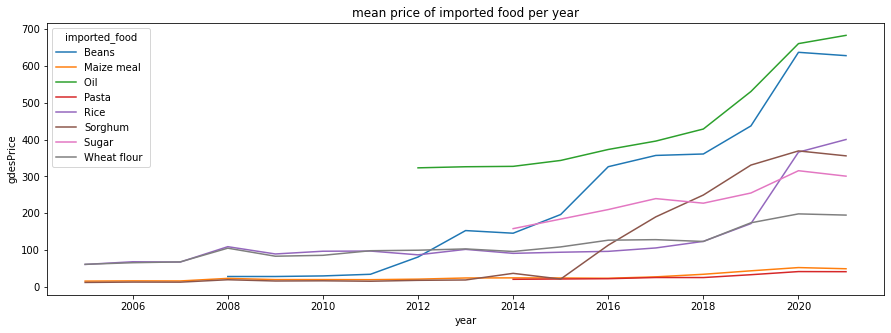

In [ ]:
#  #graph to show the tendency of the mean price of imported food per year
plt.figure(figsize=(15,5))
plt.title('mean price of imported food per year')
sns.lineplot(x="year", y='gdesPrice', ci=None, 
             hue='imported_food', data=mean_price_imported_food_per_year.reset_index())

In [ ]:
#show the mean of local food per year
mean_price_local_food_per_year = local_food.groupby(by=['commodity','year']).gdesPrice.mean().to_frame()
mean_price_local_food_per_year.reset_index('commodity', inplace=True)
mean_price_local_food_per_year.head()

commodity  gdesPrice
year                        
2005  Maize meal   49.932963
2006  Maize meal   59.877778
2007  Maize meal   50.879167
2008  Maize meal   86.886413
2009  Maize meal   76.747619

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


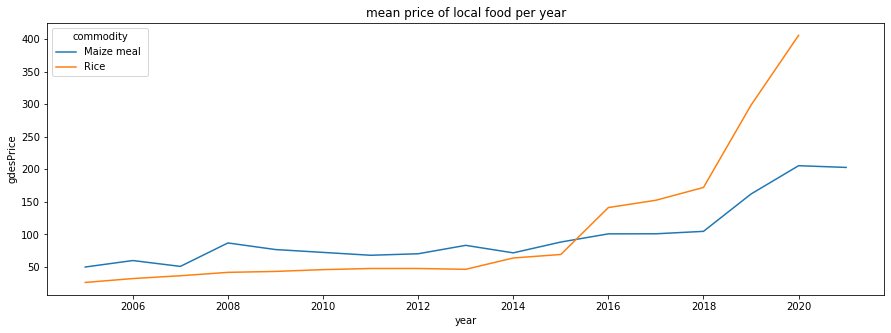

In [ ]:
# graph to show mean price of local food per year
lineplot_co(mean_price_local_food_per_year, title='mean price of local food per year')

#Product X product analysis

##local food

In [ ]:
local_food.head()

date  departement   commune    market  ...  usdPrice  origin month  year
0  15-01-2005   Artibonite  Gonaives  Gonaives  ...      0.61   local     1  2005
1  15-01-2005       Centre    Hinche    Hinche  ...      0.37   local     1  2005
2  15-01-2005       Centre    Hinche    Hinche  ...      0.25   local     1  2005
3  15-01-2005  Grande'Anse   Jeremie   Jeremie  ...      0.24   local     1  2005
4  15-01-2005  Grande'Anse   Jeremie   Jeremie  ...      0.31   local     1  2005

[5 rows x 14 columns]

In [ ]:
local_food.commodity.unique()

array(['Maize meal ', 'Rice '], dtype=object)

###Maize meal

In [ ]:
marmite_rice_local = local_food[(local_food['commodity']=='Maize meal  ') & (local_food['unit']=='Marmite')]


###Rice

In [ ]:
marmite_rice_local = local_food[(local_food['commodity']=='Rice ') & (local_food['unit']=='Marmite')]


#Analyse category X category

###Local category

In [ ]:
local_food.head(1)

date departement   commune    market  ...  usdPrice  origin month  year
0  15-01-2005  Artibonite  Gonaives  Gonaives  ...      0.61   local     1  2005

[1 rows x 14 columns]

In [ ]:
#search mean price of local category of food
mean_price_local_category_of_food_year = local_food.groupby(by=['category','year']).gdesPrice.mean().to_frame()
mean_price_local_category_of_food_year.reset_index('category', inplace=True)
mean_price_local_category_of_food_year.head()

category  gdesPrice
year                               
2005  cereals and tubers  41.935337
2006  cereals and tubers  49.991071
2007  cereals and tubers  45.751488
2008  cereals and tubers  68.019620
2009  cereals and tubers  61.243333

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


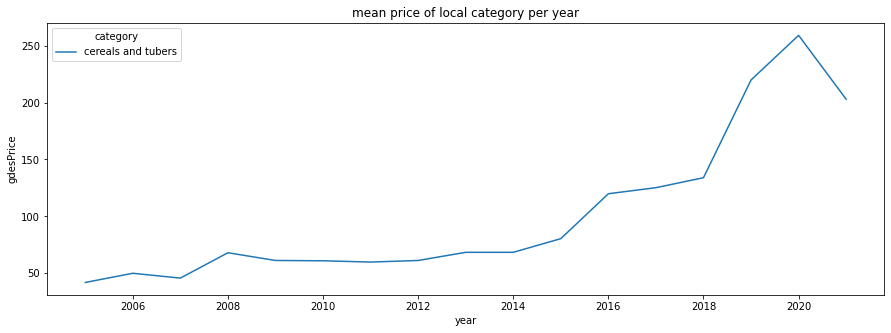

In [ ]:
# graph to show the mean price of local category by year
plt.figure(figsize=(15,5))
plt.title('mean price of local category per year')
sns.lineplot(mean_price_local_category_of_food_year.index, 'gdesPrice', ci=None, 
             hue='category', data=mean_price_local_category_of_food_year)

###Imported category

In [ ]:
#search mean price by category
mean_price_imported_food_of_food_year = imported_food.groupby(by=['category','year']).gdesPrice.mean().to_frame()
mean_price_imported_food_of_food_year.reset_index('category', inplace=True)
mean_price_imported_food_of_food_year.columns = ['category','mean_gdesPrice']
mean_price_imported_food_of_food_year.head()

category  mean_gdesPrice
year                                    
2005  cereals and tubers       42.577745
2006  cereals and tubers       46.536531
2007  cereals and tubers       46.667514
2008  cereals and tubers       71.018538
2009  cereals and tubers       56.685952

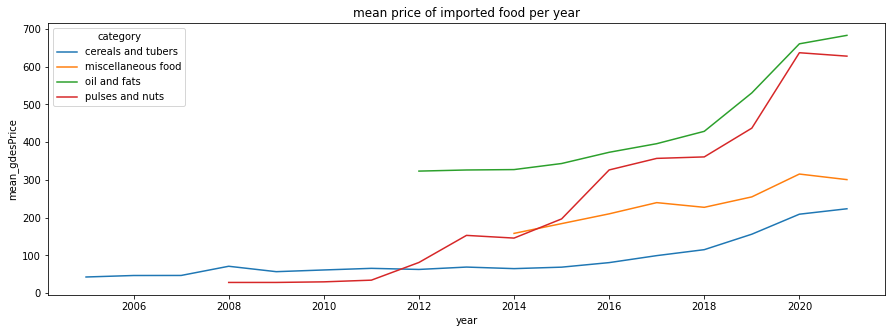

In [ ]:
# #graph to show the tendency of the mean price imported food by year
plt.figure(figsize=(15,5))
plt.title('mean price of imported food per year')
sns.lineplot(x="year", y='mean_gdesPrice', ci=None, 
             hue='category', data=mean_price_imported_food_of_food_year.reset_index())

# Local rice price variations by department

In [ ]:
food.head()

departement   commune    market  ...    origin  month  year
date                                        ...                       
15-01-2005  Artibonite  Gonaives  Gonaives  ...     local     01  2005
15-01-2005  Artibonite  Gonaives  Gonaives  ...  imported     01  2005
15-01-2005  Artibonite  Gonaives  Gonaives  ...  imported     01  2005
15-01-2005      Centre    Hinche    Hinche  ...  imported     01  2005
15-01-2005      Centre    Hinche    Hinche  ...     local     01  2005

[5 rows x 13 columns]

In [ ]:
#map
# Create latitude and longitude data
gpd_com['x']=gpd_com.geometry.centroid.x
gpd_com['y'] =gpd_com.geometry.centroid.y
gpd_com_json = gpd_com.to_json()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


##marmite rice 

In [ ]:
marmite_rice_local.head(2)

date departement   commune    market  ...  usdPrice  origin month  year
1580  15-05-2014  Artibonite  Gonaives  Gonaives  ...      1.43   local     5  2014
1582  15-05-2014      Centre    Hinche    Hinche  ...      1.43   local     5  2014

[2 rows x 14 columns]

In [ ]:
marmite_rice_local_m_ = marmite_rice_local[['date','departement','gdesPrice']]
marmite_rice_local_m_.head()

date departement  gdesPrice
1580  15-05-2014  Artibonite     140.00
1582  15-05-2014      Centre     140.00
1586  15-05-2014       North     110.00
1589  15-05-2014  North-West     130.00
1591  15-05-2014       South     174.25

In [ ]:
marmite_rice_local_m = pd.pivot_table(data=marmite_rice_local_m_, index='departement', columns='date', aggfunc='mean')
marmite_rice_local_m

gdesPrice                        ...                                 
date        15-01-2016 15-01-2017 15-01-2018  ... 15-12-2016 15-12-2017 15-12-2018
departement                                   ...                                 
Artibonite       180.0      176.0      182.0  ...      175.0      179.0      225.0
Centre           175.0      175.0      209.2  ...      175.0      207.0      280.0
Grande'Anse        NaN        NaN        NaN  ...        NaN        NaN        NaN
North            110.0      120.0      200.0  ...      120.0      207.0      200.0
North-East         NaN        NaN        NaN  ...        NaN        NaN        NaN
North-West       130.0      130.0        NaN  ...      130.0        NaN        NaN
South            188.0      150.0      200.0  ...      150.0      200.0      262.5
South-East       150.0      210.0      150.0  ...      210.0      150.0      390.0
West             125.0      125.0      175.0  ...      125.0      171.0      200.0

[9 rows x 53 columns]

In [ ]:
marmite_rice_local_m.columns
marmite_rice_local_m.columns = marmite_rice_local_m.columns.droplevel(0)
marmite_rice_local_m = marmite_rice_local_m.rename_axis(None, axis=1)

In [ ]:
gpd_dep_m = gpd_dep[['ADM1_EN','geometry']]
gpd_dep_m.rename(columns={'ADM1_EN':'departement'}, inplace=True)
gpd_dep_m

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


departement                                           geometry
0   Artibonite  POLYGON ((-72.69573 19.81251, -72.69408 19.811...
1       Centre  POLYGON ((-71.98404 19.33367, -71.98348 19.332...
2  Grande'Anse  MULTIPOLYGON (((-73.75492 18.64331, -73.75429 ...
3       Nippes  POLYGON ((-73.56737 18.58722, -73.56536 18.585...
4        North  POLYGON ((-72.55529 19.87769, -72.55468 19.877...
5   North-East  POLYGON ((-71.96148 19.73427, -71.96014 19.733...
6   North-West  MULTIPOLYGON (((-72.81638 19.95254, -72.81031 ...
7        South  MULTIPOLYGON (((-73.70372 18.10930, -73.70315 ...
8   South-East  POLYGON ((-72.76129 18.28151, -72.76129 18.281...
9         West  MULTIPOLYGON (((-73.20477 18.96978, -73.20427 ...

In [ ]:
#Merge the two dataframe
marmite_rice_local_m_gpd_dep_m = gpd_dep_m.join(marmite_rice_local_m, on= 'departement', how='right')
marmite_rice_local_m_gpd_dep_m.set_index('departement',inplace=True)
marmite_rice_local_m_gpd_dep_m.head(1)

geometry  ...  15-12-2018
departement                                                     ...            
Artibonite   POLYGON ((-72.69573 19.81251, -72.69408 19.811...  ...       225.0

[1 rows x 54 columns]

In [ ]:
marmite_rice_local_m_gpd_dep_m = marmite_rice_local_m_gpd_dep_m.T
marmite_rice_local_m_gpd_dep_m = marmite_rice_local_m_gpd_dep_m.iloc[1:,:]
marmite_rice_local_m_gpd_dep_m.reset_index(inplace=True)


In [ ]:
# marmite_rice_local_m_gpd_dep_m.drop('departement',axis=1,inplace=True)
marmite_rice_local_m_gpd_dep_m.rename(columns={'index':'date'}, inplace=True)
marmite_rice_local_m_gpd_dep_m.head()

departement        date Artibonite Centre  ...   South South-East    West
0            15-01-2016        180    175  ...     188        150     125
1            15-01-2017        176    175  ...     150        210     125
2            15-01-2018        182  209.2  ...     200        150     175
3            15-01-2019        230    280  ...     250        345  208.33
4            15-01-2020        300    400  ...  393.75        600     350

[5 rows x 10 columns]

In [ ]:
# pd.set_option('display.max_rows', None)
# # marmite_rice_local_m_gpd_dep_m

In [ ]:
##### reindex or change the order of rows
marmite_rice_local_m_gpd_dep_m_reind = marmite_rice_local_m_gpd_dep_m.reindex([0,5,10,15,21,26,31,34,38,42,45,50,1,6,11,16,22,27,32,35,39,43,46,51,2,7,12,17,23,28,33,47,52,3,8,13,18,24,29,36,40,44,48,4,9,14,19,25,30])


In [ ]:
marmite_rice_local_m_gpd_dep_m_reind.head()

departement        date Artibonite Centre  ... South South-East West
0            15-01-2016        180    175  ...   188        150  125
5            15-02-2016        172    175  ...   181        157  125
10           15-03-2016        180    175  ...   185        138  125
15           15-04-2016        180    175  ...   175        138  125
21           15-05-2016        180    175  ...   175        138  125

[5 rows x 10 columns]

In [ ]:
marmite_rice_local_m_gpd_dep_m_reind["North-East"].unique()

array([nan, 175.02, 120.0], dtype=object)

In [ ]:
cols = ["date","Artibonite","Grande'Anse","Centre", "North","North-West","North-East",
       "South", "South-East", "West"]
subsetdf = marmite_rice_local_m_gpd_dep_m_reind[cols]
subsetdf.set_index('date', inplace=True)
subsetdf.index = pd.to_datetime(subsetdf.index)
cum_sum_df = subsetdf.cumsum(axis=0)
cum_sum_df["Grande'Anse"].fillna(cum_sum_df["Grande'Anse"].mean(), inplace=True)
cum_sum_df["North-East"].fillna(cum_sum_df["North-East"].mean(), inplace=True)
cum_sum_df["North-West"].fillna(cum_sum_df["North-West"].mean(), inplace=True)

cum_sum_df.tail(10)

departement Artibonite  Grande'Anse   Centre  ...    South  South-East     West
date                                          ...                              
2019-08-15     8083.34       139.98  8823.22  ...  8119.48      9989.5  6604.89
2019-09-15     8413.34       139.98  9183.22  ...  8414.48     10421.5  6944.89
2019-10-15     8754.59       139.98  9566.55  ...  8747.81       10909  7307.39
2019-11-15     9060.59       139.98  9966.55  ...  9147.81       11449  7682.39
2020-01-15     9360.59       139.98  10366.6  ...  9541.56       12049  8032.39
2020-02-15     9660.59       139.98  10766.6  ...  9874.89       12649  8382.39
2020-03-15     9975.59       139.98  11171.6  ...  10237.4       13249  8737.39
2020-04-15     10294.3       139.98  11590.3  ...  10587.4       13849  9087.39
2020-05-15     10613.1       139.98  12009.1  ...  10937.4       14449  9437.39
2020-06-15     10958.1       139.98  12436.6  ...  11332.4       15049  9762.39

[10 rows x 9 columns]

In [ ]:
# cum_sum_df.drop(columns=["Grande'Anse","North-East"], inplace=True)
# cum_sum_df.dropna(axis=0, inplace=True)
# cum_sum_df.head()

In [ ]:
cum_sum_df.head()

departement Artibonite  Grande'Anse Centre  ... South  South-East  West
date                                        ...                        
2016-01-15         180       139.98    175  ...   188         150   125
2016-02-15         352       139.98    350  ...   369         307   250
2016-03-15         532       139.98    525  ...   554         445   375
2016-04-15         712       139.98    700  ...   729         583   500
2016-05-15         892       139.98    875  ...   904         721   625

[5 rows x 9 columns]

In [ ]:
# cum_sum_df = cum_sum_df.astype({'Centre':float, 'North':float, 'North-West':float, 'South':float, 'South-East	':float, 'West':float})
cum_sum_df['Centre'] = pd.to_numeric(cum_sum_df['Centre'])
cum_sum_df['North'] = pd.to_numeric(cum_sum_df['North'])
# cum_sum_df['North-West'] = pd.to_numeric(cum_sum_df['North-West'])
cum_sum_df['South'] = pd.to_numeric(cum_sum_df['South'])
cum_sum_df['South-East'] = pd.to_numeric(cum_sum_df['South-East'])
cum_sum_df['West'] = pd.to_numeric(cum_sum_df['West'])
cum_sum_df['Artibonite'] = pd.to_numeric(cum_sum_df['Artibonite'])

In [ ]:
import bar_chart_race as bcr
bcr.bar_chart_race(df=cum_sum_df, filename=None, figsize=(8,3), title='marmite local rice per departemnet ')

In [ ]:
# type(marmite_mais_local_m_gpd_dep_m.columns)
marmite_rice_local_m_gpd_dep_m.columns.to_list()

['date',
 'Artibonite',
 'Centre',
 "Grande'Anse",
 'North',
 'North-East',
 'North-West',
 'South',
 'South-East',
 'West']

In [ ]:
display(marmite_rice_local_m_gpd_dep_m.columns.to_list()[0])
display(marmite_rice_local_m_gpd_dep_m.columns.to_list()[1])

'date'

'Artibonite'

In [ ]:
len(marmite_rice_local_m_gpd_dep_m.columns.to_list())

10

In [ ]:
#jr_l = np.array(["15"]*(16*12)) to be deleted

In [ ]:
# marmite_mais_local_m_gpd_dep_m.columns.to_list()[2:]

In [ ]:
# #Create a gif file to show the evolution of the mean price of the marmite local Maize per departement
# image_frames= []

# for dates in marmite_rice_local_m_gpd_dep_m.columns.to_list()[2:]:
#   # print(marmite_mais_local_m_gpd_dep_m.columns.to_list()[2:8])

# # plot
#   ax = marmite_rice_local_m_gpd_dep_m.plot(column=dates,
#                                           cmap= 'OrRd',
#                                           figsize= (14,10),
#                                           legend=True,
#                                           # scheme = 'user_defined',
#                                           # classification_kwds = {'bins':[10,20,50,100,500,1000,5000,10000]},
#                                           edgecolor='black',
#                                           linewidth=0.5)
  
                                        
#   #Add  a title to the map
#   ax.set_title('Mean price marmite local rice per departement '+dates, fontdict=
#               {'fontsize':20}, pad= 12.5)
#   #removing the axes
#   ax.set_axis_off()
#   # move the legend
#   # ax.get_legend().set_bbox_to_anchor((0.18,0.6))
#   img = ax.get_figure()

#   f = io.BytesIO()
#   img.savefig(f,format= 'png', bbox_inches='tight')
#   f.seek(0)
#   image_frames.append(PIL.Image.open(f))

# #Create a GIF animation
# image_frames[0].save('Mean price marmite local rice per departement.gif', format= 'GIF',
#                      append_images= image_frames[1:],
#                      save_all = True, duration = 300,
#                      loop=3)

# f.close()



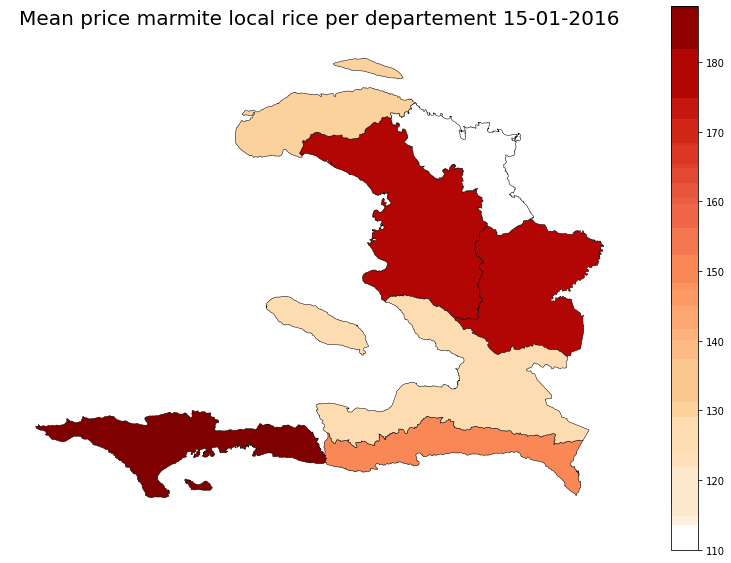

In [ ]:
Image(open('/content/drive/MyDrive/Capston_Project_Ayiti_Analytics/map/Mean price marmite local rice per departement.gif','rb').read())

In [ ]:
# def convert_picturess_to_video(pathIn, pathOut, fps, time):
# #   '''This fonction converts images to video'''
# #   frame_arrayss=[]
# #   files=[f for f in os.listdir(pathIn) if isfile(join(pathIn,f))]
# #   for i in range(len(files)):
# #     filename = pathIn + files[i]
# #     #reading images
# #     img = cv2.imread(filename)
# #     # if pictures are not in the same size
# #     #let's resize the images
# #     img = cv2.resize(img,(731,561))
# #     height, width, layers = img.shape
# #     size = (width, height)


# #     for k in range(time):
# #       frame_arrayss.append(img)
# #   out = cv2.VideoWriter(pathOut, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)
# #   for i in range(len(frame_arrayss)):
# #     out.write(frame_arrayss[i])
# #   out.release()

# # # Example: 
# # directory = '/content/drive/MyDrive/Capston_Project_Ayiti_Analytics/map'
# # pathIn = directory+'/'
# # pathOut = pathIn+'Mean_marmite_local_Maize_price_per_departement.avi'
# # fps = 1
# # time = 2
# # convert_picturess_to_video(pathIn, pathOut, fps, time)

#Petrol

In [ ]:
petrolGD.head()

In [ ]:
#Search the price of petrol in gourdes
petrolGD_exch =pd.merge(exchange_rate, petrolGD, on='date', how='right')
petrolGD_exch.dropna(inplace=True)
petrolGD_exch['diesel_unit_liter_gdes'] = petrolGD_exch['Diesel_Unit_Liter_USD'] * petrolGD_exch['Taux de change']
petrolGD_exch['Gasoline_Unit_Liter_gdes'] = petrolGD_exch['Gasoline_Unit_Liter_USD'] * petrolGD_exch['Taux de change']
petrolGD = petrolGD_exch
petrolGD.drop(columns=['Taux de change'], inplace=True)
# petrolGD.drop('Taux de change', axis=1, inplace=True)
petrolGD.set_index('date', inplace=True)
petrolGD.head()

In [ ]:
#Show the evolution of petrol over the time
plt.figure(figsize=(15,5))
plt.title('Evolution of the petrol price over the years')
sns.lineplot(x="date", y='diesel_unit_liter_gdes', ci=None, 
           data=petrolGD.reset_index(),label='Diesel Unit Liter gdes')
sns.lineplot(x="date", y='Gasoline_Unit_Liter_gdes', ci=None, 
           data=petrolGD.reset_index(),label='Gasoline Unit Liter gdes')



#Exchange rate

In [ ]:
exchange_rate.set_index('date', inplace=True)
exchange_rate.head()

In [ ]:
#Show the evolution of petrol over the time
plt.figure(figsize=(15,5))
# plt.title('Evolution of the echange rate over the years')
# plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
sns.lineplot(x="date", y='Taux de change', ci=None, 
           data=exchange_rate.reset_index(),label='exchange rate')


# 2- Understand the factors that influence the price of marmite local rice

## Exchange rate VS marmite local rice

## Impact of the exchange rate on marmite local rice prices

##Marmite local rice

In [ ]:
marmite_rice_local.head()

In [ ]:
#merge the the food dataset with the exchange rate dataset
marmite_rice_local_exh = pd.merge(marmite_rice_local, exchange_rate, on='date', how='left')
marmite_rice_local_exh.dropna(inplace=True)


In [ ]:
#
marmite_rice_local_exh_cor=marmite_rice_local_exh[['date','gdesPrice','Taux de change']]
marmite_rice_local_exh_cor.head(2)

In [ ]:
scaler= MinMaxScaler()
#normalisons les valeurs
# cols_to_norm_mmle = ['gdesPrice','Taux de change']
# marmite_mais_local_exh_cor[cols_to_norm_mmle] = StandardScaler().fit_transform(marmite_mais_local_exh_cor[cols_to_norm_mmle])
# marmite_mais_local_exh_cor.set_index('date',inplace=True)
# marmite_mais_local_exh_cor.head()

cols_to_norm_mmle = ['gdesPrice','Taux de change']
marmite_rice_local_exh_cor[cols_to_norm_mmle] = StandardScaler().fit_transform(marmite_rice_local_exh_cor[cols_to_norm_mmle])
marmite_rice_local_exh_cor.set_index('date',inplace=True)
marmite_rice_local_exh_cor.head()

In [ ]:
# plt.figure(figsize=(5,3))
# sns.heatmap(marmite_mais_local_exh_cor.corr(), annot=True, cmap='Blues')
# plt.title('Correlation HeatMap')

plt.figure(figsize=(5,3))
sns.heatmap(marmite_rice_local_exh_cor.corr(), annot=True, cmap='Blues')
plt.title('Correlation HeatMap')


In [ ]:
# plt.figure(figsize=(15,5))
# sns.lineplot(data=marmite_mais_local_exh_cor.reset_index(), x='date', y='gdesPrice', label='Price marmite local maize')
# # plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
# sns.lineplot(data=marmite_mais_local_exh_cor.reset_index(), x='date', y='Taux de change', label='Exchange rate')
# plt.title('Evolution of the mean price of local marmite maize and the exhange rate')

plt.figure(figsize=(15,5))
sns.lineplot(data=marmite_rice_local_exh_cor.reset_index(), x='date', y='gdesPrice', label='Price marmite local rice')
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
sns.lineplot(data=marmite_rice_local_exh_cor.reset_index(), x='date', y='Taux de change', label='Exchange rate')
plt.title('Evolution of the mean price of local marmite rice and the exhange rate')


The exchange rate evolves in the same way as the price of a pot of local rice, but we don't know if the evolution of one causes the other.

###Let's see if the exchange rate has an impact on the price of the marmite rice

In [ ]:
marmite_rice_local_exh_cor.head()

Test de causalite de granger

In [ ]:
# from pandas.plotting import lag_plot
   
# f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
# f2.tight_layout()

# lag_plot(marmite_mais_local_exh_cor['gdesPrice'], ax=ax4)
# ax4.set_title('Gourdes price of the marmite maize ');

# lag_plot(marmite_mais_local_exh_cor['Taux de change'], ax=ax5)
# ax5.set_title('Taux de change');

# #lag_plot(series3, ax=ax6)
# #ax6.set_title('Taux de change and Gourdes price of the marmite maize');

# plt.show()


from pandas.plotting import lag_plot
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(marmite_rice_local_exh_cor['gdesPrice'], ax=ax4)
ax4.set_title('Gourdes price of the marmite of rice ');

lag_plot(marmite_rice_local_exh_cor['Taux de change'], ax=ax5)
ax5.set_title('Taux de change');

#lag_plot(series3, ax=ax6)
#ax6.set_title('Taux de change and Gourdes price of the marmite maize');

plt.show()

Result: Data is not stationary. We will have to make it stationary using difference operation

In [ ]:
#difference operation for sttionarity
rawData = marmite_rice_local_exh_cor.copy(deep=True)

In [ ]:
marmite_rice_local_exh_cor['gdesPrice'] = marmite_rice_local_exh_cor['gdesPrice'] - marmite_rice_local_exh_cor['gdesPrice'].shift(1)
marmite_rice_local_exh_cor['Taux de change'] = marmite_rice_local_exh_cor['Taux de change'] - marmite_rice_local_exh_cor['Taux de change'].shift(1)
marmite_rice_local_exh_cor = marmite_rice_local_exh_cor.dropna()

In [ ]:
# split data into train and test. We will need this later for VAR analysis
partition = np.random.rand(len(marmite_rice_local_exh_cor)) < 0.8
train = marmite_rice_local_exh_cor[partition]
test = marmite_rice_local_exh_cor[~partition]

In [ ]:
## ADF Null hypothesis: there is a unit root, meaning series is non-stationary
from statsmodels.tsa.stattools import adfuller

X1 = np.array(marmite_rice_local_exh_cor['gdesPrice'])
X1 = X1[~np.isnan(X1)]

result = adfuller(X1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
X2 = np.array(marmite_rice_local_exh_cor['Taux de change'])
X2 = X2[~np.isnan(X2)]

result = adfuller(X2)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [ ]:
## KPSS Null hypothesis: there is a no unit root, meaning series is stationary
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(X1)
kpss_test(X2)

Result: ADF Null Hypothesis is rejected: Thus, data is stationary KPSS Null Hypothesis could not be rejected. Thus, data is stationary

In [ ]:
from pandas.plotting import lag_plot
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(marmite_rice_local_exh_cor['gdesPrice'], ax=ax4)
ax4.set_title('gdesPrice');

lag_plot(marmite_rice_local_exh_cor['Taux de change'], ax=ax5)
ax5.set_title('Gourdes price of the marmite maize');

#lag_plot(series3, ax=ax6)
#ax6.set_title('Taux de change and Gourdes price of the marmite maize');

plt.show()

Result: lag plot is in confirmatory with ADF test and KPSS test

Step 2: Let the maximum order of integration for the group of time-series be m. So, if there are two time-series and one is found to be I(1) and the other is I(2), then m = 2. If one is I(0) and the other is I(1), then m = 1, etc.

Result: We saw above that for our case m = 1

Step 3: Set up a VAR model in the levels of the data, regardless of the orders of integration of the various time-series. Most importantly, you must not difference the data, no matter what you found at Step 1.//

Step 4: Determine the appropriate maximum lag length for the variables in the VAR, say p, using the usual methods. Specifically, base the choice of p on the usual information criteria, such as AIC, SIC.

In [ ]:
# obtain the lag P for VAR
rawData = rawData.dropna()
model = VAR(rawData) #recall that rawData is w/o difference operation
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    try:
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
    except:
        continue

Result: The lag-order p = 5 on the basis of Akaike Information Criterion (AIC)

Step 5: Make sure that the VAR is well-specified. For example, ensure that there is no serial correlation in the residuals. If need be, increase p until any autocorrelation issues are resolved.

In [ ]:
train.head()

In [ ]:
array_k = np.asarray(train)

In [ ]:
# marmite_mais_local_exh_cor.head()

In [ ]:
  # array_k[:10]

In [ ]:
model = VAR(train)
# array_k.astype('float64')
model_fitted = model.fit(5)

In [ ]:
# Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
# The value of this statistic can vary between 0 and 4. 
# The closer it is to the value 2, then there is no significant serial correlation. 
# The closer to 0, there is a positive serial correlation, 
# and the closer it is to 4 implies negative serial correlation.


from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(marmite_rice_local_exh_cor.columns, out):
    print(col, ':', round(val, 2))

Result: There is no significant correlation between in the residuals

Step 6: If two or more of the time-series have the same order of integration, at Step 1, then test to see if they are cointegrated, preferably using Johansen’s methodology (based on your VAR) for a reliable result.

In [ ]:
# I could not perform Johansen's test. Instead I check for co-integration using t-statistics

import statsmodels.tsa.stattools as ts 
result=ts.coint(marmite_rice_local_exh_cor['gdesPrice'], marmite_rice_local_exh_cor['Taux de change'])
print(result)

Result: The p-valus < 0.05. Thus rejecting the null hypothesis. Thus they are cointegrated.

Step 7: No matter what you conclude about cointegration at Step 6, this is not going to affect what follows. It just provides a possible cross-check on the validity of your results at the very end of the analysis.

Step 8: Now take the preferred VAR model and add in m additional lags of each of the variables into each of the equations.

In [ ]:
model = VAR(train)
model_fitted = model.fit(5)
#get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

Step 9 and Step 10: Test for Granger non-causality. It’s essential that you don’t include the coefficients for the ‘extra’ m lags when you perform the tests. They are there just to fix up the asymptotics.

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=lag_order #because we got this value before. We are not suppose to add 1 to it
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(marmite_rice_local_exh_cor[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    print(p_values)
    return df

newdf = grangers_causation_matrix(train, variables = train.columns)

In [ ]:
newdf

In [ ]:
#xCy = Taux de change causes gdesPrice
#yXx = gdesPrice causes Taux de change

In [ ]:
print(grangercausalitytests(marmite_rice_local_exh_cor[['gdesPrice', 'Taux de change']], maxlag=1, addconst=True, verbose=True))


Lineplot p-value and gourdes price of marmite of rice

The Grangers causality test shows us that the change in the exchange rate causes the change in the price of the local marmite rice 

## Impact of the diesel price on marmite local rice

In [ ]:
petrolGD.head(2)

##Marmite local Rice

In [ ]:
marmite_rice_local.head(2)

In [ ]:
#merge the the food dataset with the petrol dataset
marmite_rice_local_diesel = pd.merge(marmite_rice_local, petrolGD, on='date', how='left')
marmite_rice_local_diesel.dropna(inplace=True)

In [ ]:
marmite_rice_local_diesel_cor=marmite_rice_local_diesel[['date','gdesPrice','diesel_unit_liter_gdes']]
marmite_rice_local_diesel_cor.head(2)

In [ ]:
#normalisons les valeurs
scaler= MinMaxScaler()
cols_to_norm_mmle = ['gdesPrice','diesel_unit_liter_gdes']
marmite_rice_local_diesel_cor[cols_to_norm_mmle] = StandardScaler().fit_transform(marmite_rice_local_diesel_cor[cols_to_norm_mmle])
marmite_rice_local_diesel_cor.set_index('date',inplace=True)
marmite_rice_local_diesel_cor.head()

In [ ]:
plt.figure(figsize=(5,3))
sns.heatmap(marmite_rice_local_diesel_cor.corr(), annot=True, cmap='Blues')
plt.title('Correlation HeatMap')

In [ ]:
plt.figure(figsize=(20,5))
sns.lineplot(data=marmite_rice_local_diesel_cor.reset_index(), x='date', y='gdesPrice', label='Price marmite local rice')
sns.lineplot(data=marmite_rice_local_diesel_cor.reset_index(), x='date', y='diesel_unit_liter_gdes', label='diesel unit liter gdes')
plt.title('Evolution of the mean price of local marmite rice and the diesel unit liter in gdes')

Le prix du diesel n'evolue pas de la meme maniere que le prix de la marmite de riz local

In [ ]:

# sns.lineplot()

# # Start and end of the date range to extract
# start, end = '2018-12', '2019-12'
# # Plot daily and weekly resampled time series together
# #plt.figure(figsize=(8,12))
# fig, ax = plt.subplots(figsize=(20,8))
# ax.plot(datepresence.loc[start:end],
# marker='.', linestyle='-', linewidth=0.5, label='Quantité de presence par jour')
# ax.plot(presenceweek.loc[start:end],
# marker='.', markersize=8, linestyle='-', label='Moyenne par jour pour la semaine')
# ax.set_ylabel('Presence')
# plt.title(' Evolution des Présences par jour au CCKD en 2019')

# ax.legend();

Let's see if the diesel price has an impact on the price of the marmite local rice

In [ ]:
marmite_rice_local_diesel_cor.head()

Test de causalite de grangers

In [ ]:
from pandas.plotting import lag_plot
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(marmite_rice_local_diesel_cor['gdesPrice'], ax=ax4)
ax4.set_title('Gourdes price of the marmite of rice');

lag_plot(marmite_rice_local_diesel_cor['diesel_unit_liter_gdes'], ax=ax5)
ax5.set_title('diesel unit liter gdes');

#lag_plot(series3, ax=ax6)
#ax6.set_title('###########');

plt.show()

Result: Data is not stationary. We will have to make it stationary using difference operation

In [ ]:
#difference operation for sttionarity
rawData = marmite_rice_local_diesel_cor.copy(deep=True)

In [ ]:
marmite_rice_local_diesel_cor['gdesPrice'] = marmite_rice_local_diesel_cor['gdesPrice'] - marmite_rice_local_diesel_cor['gdesPrice'].shift(1)
marmite_rice_local_diesel_cor['diesel_unit_liter_gdes'] = marmite_rice_local_diesel_cor['diesel_unit_liter_gdes'] - marmite_rice_local_diesel_cor['diesel_unit_liter_gdes'].shift(1)
marmite_rice_local_diesel_cor = marmite_rice_local_diesel_cor.dropna()

In [ ]:
# split data into train and test. We will need this later for VAR analysis
partition = np.random.rand(len(marmite_rice_local_diesel_cor)) < 0.8
train = marmite_rice_local_diesel_cor[partition]
test = marmite_rice_local_diesel_cor[~partition]

In [ ]:
## ADF Null hypothesis: there is a unit root, meaning series is non-stationary
from statsmodels.tsa.stattools import adfuller

X1 = np.array(marmite_rice_local_diesel_cor['gdesPrice'])
X1 = X1[~np.isnan(X1)]

result = adfuller(X1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
X2 = np.array(marmite_rice_local_diesel_cor['diesel_unit_liter_gdes'])
X2 = X2[~np.isnan(X2)]

result = adfuller(X2)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [ ]:
## KPSS Null hypothesis: there is a no unit root, meaning series is stationary
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(X1)
kpss_test(X2)

Result: ADF Null Hypothesis is rejected: Thus, data is stationary KPSS Null Hypothesis could not be rejected. Thus, data is stationary

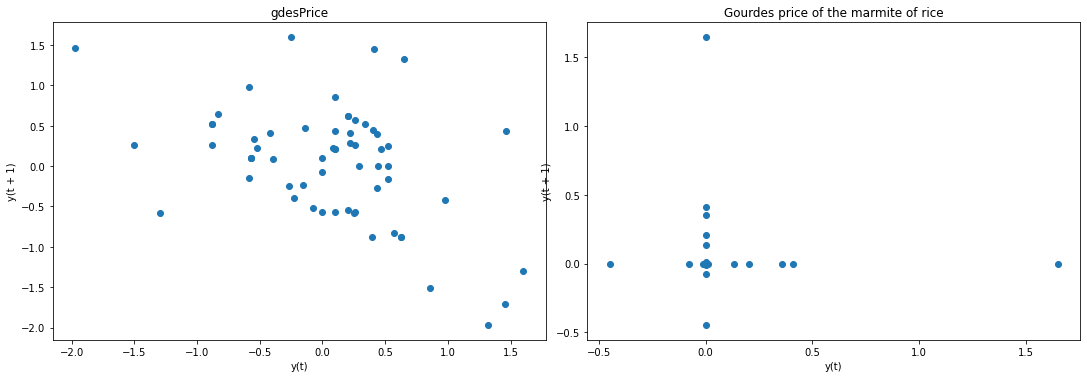

In [ ]:
from pandas.plotting import lag_plot
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(marmite_rice_local_diesel_cor['gdesPrice'], ax=ax4)
ax4.set_title('gdesPrice');

lag_plot(marmite_rice_local_diesel_cor['diesel_unit_liter_gdes'], ax=ax5)
ax5.set_title('Gourdes price of the marmite of rice');

#lag_plot(series3, ax=ax6)
#ax6.set_title('diesel unit liter gdes and Gourdes price of the marmite rice');

plt.show()

Result: lag plot is in confirmatory with ADF test and KPSS test

Step 2: Let the maximum order of integration for the group of time-series be m. So, if there are two time-series and one is found to be I(1) and the other is I(2), then m = 2. If one is I(0) and the other is I(1), then m = 1, etc.

Result: We saw above that for our case m = 1

Step 3: Set up a VAR model in the levels of the data, regardless of the orders of integration of the various time-series. Most importantly, you must not difference the data, no matter what you found at Step 1.//

Step 4: Determine the appropriate maximum lag length for the variables in the VAR, say p, using the usual methods. Specifically, base the choice of p on the usual information criteria, such as AIC, SIC.

In [ ]:
# obtain the lag P for VAR
rawData = rawData.dropna()
model = VAR(rawData) #recall that rawData is w/o difference operation
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    try:
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
    except:
        continue

Lag Order = 1
AIC :  -3.7249697588695767
BIC :  -3.520861689689431
FPE :  0.024117306365770017
HQIC:  -3.6446930576107848 

Lag Order = 2
AIC :  -3.6910300723773983
BIC :  -3.3479438812410933
FPE :  0.024963812208628984
HQIC:  -3.556325777975715 

Lag Order = 3
AIC :  -3.9321206423358332
BIC :  -3.44765778826327
FPE :  0.01964191023021075
HQIC:  -3.7422551095819085 

Lag Order = 4
AIC :  -3.7926062045461326
BIC :  -3.1643028358795027
FPE :  0.022639831668759363
HQIC:  -3.546842216688761 

Lag Order = 5
AIC :  -3.653488004472109
BIC :  -2.87881302538862
FPE :  0.02613023374424389
HQIC:  -3.3510862672665676 

Lag Order = 6
AIC :  -3.742491077343012
BIC :  -2.818844210546341
FPE :  0.024064729253141487
HQIC:  -3.3827119679452275 

Lag Order = 7
AIC :  -3.6124607972034815
BIC :  -2.537170656237928
FPE :  0.027678499052482184
HQIC:  -3.194566406445614 

Lag Order = 8
AIC :  -3.556183623071079
BIC :  -2.326505810839024
FPE :  0.029698054293605457
HQIC:  -3.0794401358017356 

Lag Order = 9
AI

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Result: The lag-order p = 3 on the basis of Akaike Information Criterion (AIC)

Step 5: Make sure that the VAR is well-specified. For example, ensure that there is no serial correlation in the residuals. If need be, increase p until any autocorrelation issues are resolved.

In [ ]:
array_k = np.asarray(train)

In [ ]:
model = VAR(train)
model_fitted = model.fit(5)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
# Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
# The value of this statistic can vary between 0 and 4. 
# The closer it is to the value 2, then there is no significant serial correlation. 
# The closer to 0, there is a positive serial correlation, 
# and the closer it is to 4 implies negative serial correlation.


from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(marmite_rice_local_diesel_cor.columns, out):
    print(col, ':', round(val, 2))

gdesPrice : 1.99
diesel_unit_liter_gdes : 1.89


Result: There is no significant correlation between in the residuals

Step 6: If two or more of the time-series have the same order of integration, at Step 1, then test to see if they are cointegrated, preferably using Johansen’s methodology (based on your VAR) for a reliable result.

In [ ]:
# I could not perform Johansen's test. Instead I check for co-integration using t-statistics

import statsmodels.tsa.stattools as ts 
result=ts.coint(marmite_rice_local_diesel_cor['gdesPrice'], marmite_rice_local_diesel_cor['diesel_unit_liter_gdes'])
print(result)

(-5.7136228054203775, 6.558898728403397e-06, array([-4.08180545, -3.43645497, -3.11356405]))


Result: The p-valus < 0.05. Thus rejecting the null hypothesis. Thus they are cointegrated.

Step 7: No matter what you conclude about cointegration at Step 6, this is not going to affect what follows. It just provides a possible cross-check on the validity of your results at the very end of the analysis.

Step 8: Now take the preferred VAR model and add in m additional lags of each of the variables into each of the equations.

In [ ]:
model = VAR(train)
model_fitted = model.fit(5)
#get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

5


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Step 9 and Step 10: Test for Granger non-causality. It’s essential that you don’t include the coefficients for the ‘extra’ m lags when you perform the tests. They are there just to fix up the asymptotics.

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=lag_order #because we got this value before. We are not suppose to add 1 to it
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(marmite_rice_local_diesel_cor[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

newdf = grangers_causation_matrix(train, variables = train.columns)

In [ ]:
newdf

gdesPrice_x  diesel_unit_liter_gdes_x
gdesPrice_y                    1.0000                    0.5555
diesel_unit_liter_gdes_y       0.2064                    1.0000

In [ ]:
print(grangercausalitytests(marmite_rice_local_diesel_cor[['gdesPrice', 'diesel_unit_liter_gdes']], maxlag=1, addconst=True, verbose=True))



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3307  , p=0.5674  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.3476  , p=0.5555  , df=1
likelihood ratio test: chi2=0.3466  , p=0.5561  , df=1
parameter F test:         F=0.3307  , p=0.5674  , df_denom=59, df_num=1
{1: ({'ssr_ftest': (0.33073355973069707, 0.5674142153277366, 59.0, 1), 'ssr_chi2test': (0.3475505203949698, 0.5555030069300835, 1), 'lrtest': (0.3465800216538639, 0.5560555108097165, 1), 'params_ftest': (0.3307335597306932, 0.5674142153277366, 59.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fb5c6f0d310>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fb5c6f76250>, array([[0., 1., 0.]])])}


The Grangers causality test shows us that the price of diesel does not cause the change in the price of the local marmite rice

#Gasoline price VS marmite local rice

# Impact of the gasoline price on the local marmite price

#Marmite local rice

In [ ]:
marmite_rice_local.head(3)

date departement      commune  ... origin  month  year
1580  15-05-2014  Artibonite     Gonaives  ...  local      5  2014
1582  15-05-2014      Centre       Hinche  ...  local      5  2014
1586  15-05-2014       North  Cap-Haitien  ...  local      5  2014

[3 rows x 14 columns]

In [ ]:
petrolGD.head()

Diesel_Unit_Liter_USD  ...  Gasoline_Unit_Liter_gdes
date                               ...                          
15-10-2016                 0.5900  ...                 47.350844
15-11-2016                 0.5925  ...                 47.639269
15-12-2016                 0.5925  ...                 49.872691
15-10-2017                 0.7450  ...                 57.887849
15-11-2017                 0.7400  ...                 57.860880

[5 rows x 4 columns]

In [ ]:
#merge the the food dataset with the petrol dataset
marmite_rice_local_gasoline = pd.merge(marmite_rice_local, petrolGD, on='date', how='left')
marmite_rice_local_gasoline.dropna(inplace=True)

In [ ]:
marmite_rice_local_gasoline_cor=marmite_rice_local_gasoline[['date','gdesPrice','Gasoline_Unit_Liter_gdes']]
marmite_rice_local_gasoline_cor.head(2)

date  gdesPrice  Gasoline_Unit_Liter_gdes
90  15-10-2016      165.0                 47.350844
91  15-10-2016      175.0                 47.350844

In [ ]:
#normalisons les valeurs
scaler= MinMaxScaler()
cols_to_norm_mmle = ['gdesPrice','Gasoline_Unit_Liter_gdes']
marmite_rice_local_gasoline_cor[cols_to_norm_mmle] = StandardScaler().fit_transform(marmite_rice_local_gasoline_cor[cols_to_norm_mmle])
marmite_rice_local_gasoline_cor.set_index('date',inplace=True)
marmite_rice_local_gasoline_cor.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


gdesPrice  Gasoline_Unit_Liter_gdes
date                                           
15-10-2016  -0.614933                 -1.577758
15-10-2016  -0.511101                 -1.577758
15-10-2016  -1.082179                 -1.577758
15-10-2016  -0.978346                 -1.577758
15-10-2016  -0.770682                 -1.577758

Text(0.5, 1.0, 'Correlation HeatMap')

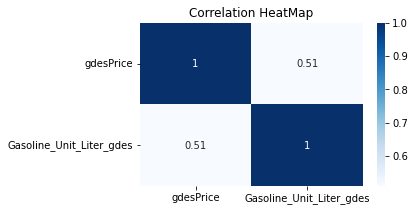

In [ ]:
plt.figure(figsize=(5,3))
sns.heatmap(marmite_rice_local_gasoline_cor.corr(), annot=True, cmap='Blues')
plt.title('Correlation HeatMap')

Text(0.5, 1.0, 'Evolution of the mean price of local marmite rice and the gasoline unit liter in gdes')

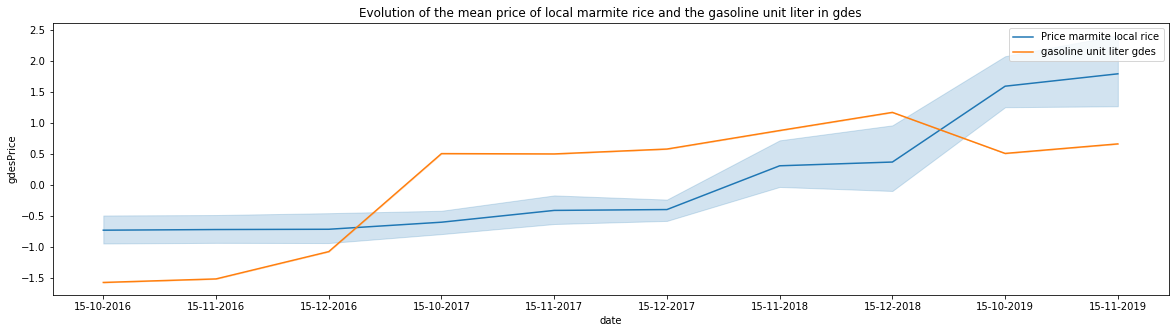

In [ ]:
plt.figure(figsize=(20,5))
sns.lineplot(data=marmite_rice_local_gasoline_cor.reset_index(), x='date', y='gdesPrice', label='Price marmite local rice')
sns.lineplot(data=marmite_rice_local_gasoline_cor.reset_index(), x='date', y='Gasoline_Unit_Liter_gdes', label='gasoline unit liter gdes')
plt.title('Evolution of the mean price of local marmite rice and the gasoline unit liter in gdes')

The price of gasoline does not change in the same way as the price of marmite local rice

#Let's see if the gasoline price has an impact on the price of the marmite local rice

In [ ]:
marmite_rice_local_gasoline_cor.head()

gdesPrice  Gasoline_Unit_Liter_gdes
date                                           
15-10-2016  -0.614933                 -1.577758
15-10-2016  -0.511101                 -1.577758
15-10-2016  -1.082179                 -1.577758
15-10-2016  -0.978346                 -1.577758
15-10-2016  -0.770682                 -1.577758

#Test de causalite de Grangers

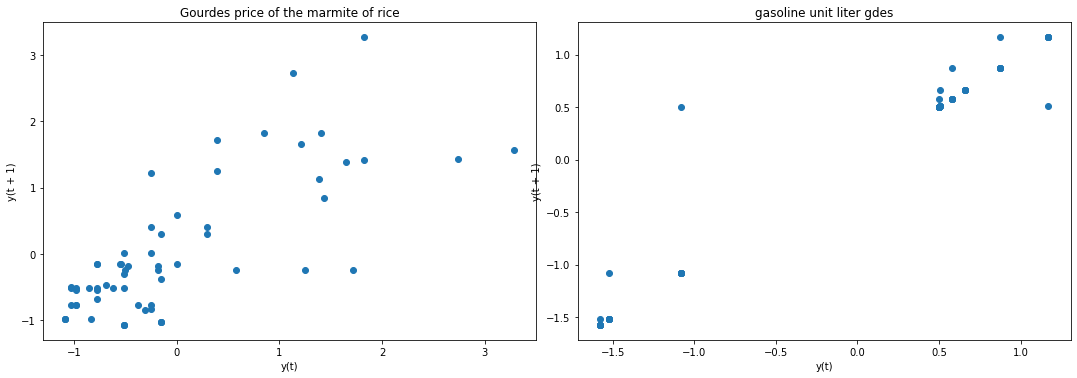

In [ ]:
from pandas.plotting import lag_plot
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(marmite_rice_local_gasoline_cor['gdesPrice'], ax=ax4)
ax4.set_title('Gourdes price of the marmite of rice');

lag_plot(marmite_rice_local_gasoline_cor['Gasoline_Unit_Liter_gdes'], ax=ax5)
ax5.set_title('gasoline unit liter gdes');

#lag_plot(series3, ax=ax6)
#ax6.set_title('###########');

plt.show()

Result: Data is not stationary. We will have to make it stationary using difference operation

In [ ]:
#difference operation for sttionarity
rawData = marmite_rice_local_gasoline_cor.copy(deep=True)

In [ ]:
marmite_rice_local_gasoline_cor['gdesPrice'] = marmite_rice_local_gasoline_cor['gdesPrice'] - marmite_rice_local_gasoline_cor['gdesPrice'].shift(1)
marmite_rice_local_gasoline_cor['Gasoline_Unit_Liter_gdes'] = marmite_rice_local_gasoline_cor['Gasoline_Unit_Liter_gdes'] - marmite_rice_local_gasoline_cor['Gasoline_Unit_Liter_gdes'].shift(1)
marmite_rice_local_gasoline_cor = marmite_rice_local_gasoline_cor.dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# split data into train and test. We will need this later for VAR analysis
partition = np.random.rand(len(marmite_rice_local_gasoline_cor)) < 0.8
train = marmite_rice_local_gasoline_cor[partition]
test = marmite_rice_local_gasoline_cor[~partition]

In [ ]:
## ADF Null hypothesis: there is a unit root, meaning series is non-stationary
from statsmodels.tsa.stattools import adfuller

X1 = np.array(marmite_rice_local_gasoline_cor['gdesPrice'])
X1 = X1[~np.isnan(X1)]

result = adfuller(X1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
X2 = np.array(marmite_rice_local_gasoline_cor['Gasoline_Unit_Liter_gdes'])
X2 = X2[~np.isnan(X2)]

result = adfuller(X2)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.878390
p-value: 0.000000
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594
ADF Statistic: -7.939910
p-value: 0.000000
Critical Values:
	1%: -3.541
	5%: -2.909
	10%: -2.592


In [ ]:
## KPSS Null hypothesis: there is a no unit root, meaning series is stationary
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(X1)
kpss_test(X2)

KPSS Statistic: 0.1893837019595737
p-value: 0.1
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
KPSS Statistic: 0.16810107963392704
p-value: 0.1
num lags: 1
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2003: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2003: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Result: ADF Null Hypothesis is rejected: Thus, data is stationary KPSS Null Hypothesis could not be rejected. Thus, data is stationary

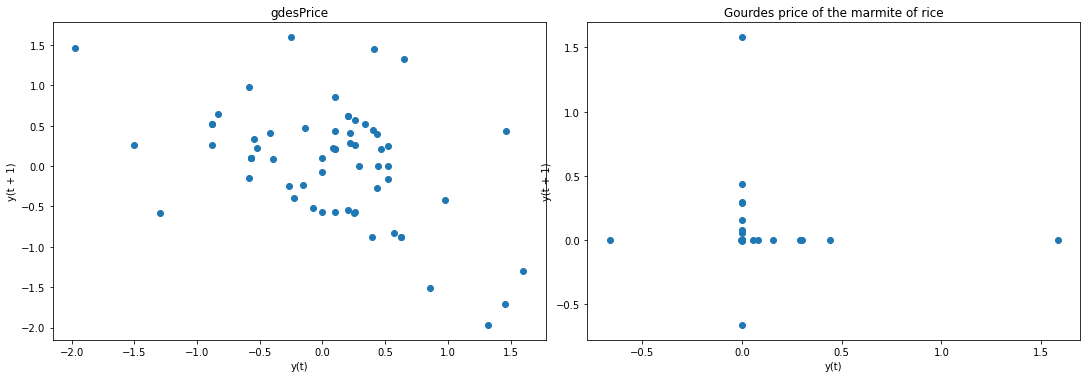

In [ ]:
from pandas.plotting import lag_plot
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(marmite_rice_local_gasoline_cor['gdesPrice'], ax=ax4)
ax4.set_title('gdesPrice');

lag_plot(marmite_rice_local_gasoline_cor['Gasoline_Unit_Liter_gdes'], ax=ax5)
ax5.set_title('Gourdes price of the marmite of rice');

#lag_plot(series3, ax=ax6)
#ax6.set_title('gasoline unit liter gdes and Gourdes price of the marmite rice');

plt.show()

Result: lag plot is in confirmatory with ADF test and KPSS test

Step 2: Let the maximum order of integration for the group of time-series be m. So, if there are two time-series and one is found to be I(1) and the other is I(2), then m = 2. If one is I(0) and the other is I(1), then m = 1, etc.

Result: We saw above that for our case m = 1

Step 3: Set up a VAR model in the levels of the data, regardless of the orders of integration of the various time-series. Most importantly, you must not difference the data, no matter what you found at Step 1.//

Step 4: Determine the appropriate maximum lag length for the variables in the VAR, say p, using the usual methods. Specifically, base the choice of p on the usual information criteria, such as AIC, SIC.

In [ ]:
# obtain the lag P for VAR
rawData = rawData.dropna()
model = VAR(rawData) #recall that rawData is w/o difference operation
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    try:
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
    except:
        continue

Lag Order = 1
AIC :  -3.695769129893695
BIC :  -3.4916610607135494
FPE :  0.024831929830332486
HQIC:  -3.6154924286349033 

Lag Order = 2
AIC :  -3.6617340303929553
BIC :  -3.3186478392566503
FPE :  0.025705971179805796
HQIC:  -3.527029735991272 

Lag Order = 3
AIC :  -3.9130920367717237
BIC :  -3.4286291826991606
FPE :  0.020019247104087205
HQIC:  -3.723226504017799 

Lag Order = 4
AIC :  -3.7693615973592034
BIC :  -3.1410582286925735
FPE :  0.023172249613243285
HQIC:  -3.5235976095018318 

Lag Order = 5
AIC :  -3.6299034234330216
BIC :  -2.8552284443495326
FPE :  0.026753829071761593
HQIC:  -3.32750168622748 

Lag Order = 6
AIC :  -3.728785113120398
BIC :  -2.8051382463237275
FPE :  0.024396830254690912
HQIC:  -3.369006003722614 

Lag Order = 7
AIC :  -3.601400411908968
BIC :  -2.526110270943415
FPE :  0.027986333160134918
HQIC:  -3.183506021151101 

Lag Order = 8
AIC :  -3.558617642216059
BIC :  -2.328939829984004
FPE :  0.02962585656186113
HQIC:  -3.0818741549467155 

Lag Order = 9

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Result: The lag-order p = 1 on the basis of Akaike Information Criterion (AIC)

Step 5: Make sure that the VAR is well-specified. For example, ensure that there is no serial correlation in the residuals. If need be, increase p until any autocorrelation issues are resolved.

In [ ]:
array_k = np.asarray(train)

In [ ]:
model = VAR(train)
model_fitted = model.fit(5)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
# Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
# The value of this statistic can vary between 0 and 4. 
# The closer it is to the value 2, then there is no significant serial correlation. 
# The closer to 0, there is a positive serial correlation, 
# and the closer it is to 4 implies negative serial correlation.


from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(marmite_rice_local_gasoline_cor.columns, out):
    print(col, ':', round(val, 2))

gdesPrice : 1.84
Gasoline_Unit_Liter_gdes : 2.04


Result: There is no significant correlation between in the residuals

Step 6: If two or more of the time-series have the same order of integration, at Step 1, then test to see if they are cointegrated, preferably using Johansen’s methodology (based on your VAR) for a reliable result.

In [ ]:
# I could not perform Johansen's test. Instead I check for co-integration using t-statistics

import statsmodels.tsa.stattools as ts 
result=ts.coint(marmite_rice_local_gasoline_cor['gdesPrice'], marmite_rice_local_gasoline_cor['Gasoline_Unit_Liter_gdes'])
print(result)

(-5.841339698646696, 3.5423159800664606e-06, array([-4.08180545, -3.43645497, -3.11356405]))


Result: The p-valus < 0.05. Thus rejecting the null hypothesis. Thus they are cointegrated.

Step 7: No matter what you conclude about cointegration at Step 6, this is not going to affect what follows. It just provides a possible cross-check on the validity of your results at the very end of the analysis.

Step 8: Now take the preferred VAR model and add in m additional lags of each of the variables into each of the equations.

In [ ]:
model = VAR(train)
model_fitted = model.fit(5)
#get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

5


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Step 9 and Step 10: Test for Granger non-causality. It’s essential that you don’t include the coefficients for the ‘extra’ m lags when you perform the tests. They are there just to fix up the asymptotics.

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=lag_order #because we got this value before. We are not suppose to add 1 to it
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(marmite_rice_local_gasoline_cor[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

newdf = grangers_causation_matrix(train, variables = train.columns)

In [ ]:
newdf

gdesPrice_x  Gasoline_Unit_Liter_gdes_x
gdesPrice_y                      1.0000                      0.5229
Gasoline_Unit_Liter_gdes_y       0.3062                      1.0000

In [ ]:
print(grangercausalitytests(marmite_rice_local_gasoline_cor[['gdesPrice', 'Gasoline_Unit_Liter_gdes']], maxlag=1, addconst=True, verbose=True))



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2318  , p=0.6319  , df_denom=59, df_num=1
ssr based chi2 test:   chi2=0.2436  , p=0.6216  , df=1
likelihood ratio test: chi2=0.2431  , p=0.6219  , df=1
parameter F test:         F=0.2318  , p=0.6319  , df_denom=59, df_num=1
{1: ({'ssr_ftest': (0.23183519249262913, 0.6319474965181953, 59.0, 1), 'ssr_chi2test': (0.24362342261937295, 0.6216012496266534, 1), 'lrtest': (0.24314602464396273, 0.6219430666763508, 1), 'params_ftest': (0.23183519249262677, 0.6319474965182003, 59.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fb5c6e1abd0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fb5c6a7f090>, array([[0., 1., 0.]])])}


The Grangers causality test shows us that the price of gasoline cause the change in the price of the local marmite rice

#Merge the datasets

##Modele ARDL

###Pound imported rice at Port-au-Prince + Exchange rate

In [ ]:
pound_imported_rice_p_au_p = food[(food.market=='Port-au-Prince') & (food.commodity=="Rice ") & (food.unit=="Pound") & (food.origin=="imported")]
pound_imported_rice_p_au_p_cg = pound_imported_rice_p_au_p[["commodity","gdesPrice"]]

In [ ]:
petrolGD.head()

Diesel_Unit_Liter_USD  ...  Gasoline_Unit_Liter_gdes
date                               ...                          
15-10-2016                 0.5900  ...                 47.350844
15-11-2016                 0.5925  ...                 47.639269
15-12-2016                 0.5925  ...                 49.872691
15-10-2017                 0.7450  ...                 57.887849
15-11-2017                 0.7400  ...                 57.860880

[5 rows x 4 columns]

In [ ]:
 pound_imported_rice_p_au_p_cg.reset_index('date', inplace=True)

In [ ]:
df_final = pd.merge(pound_imported_rice_p_au_p_cg, exchange_rate, on='date', how='left')

In [ ]:
df_final.head()

date commodity  gdesPrice  Taux de change
0  15-01-2005     Rice       14.20             NaN
1  15-02-2005     Rice       14.00             NaN
2  15-03-2005     Rice       14.25             NaN
3  15-04-2005     Rice       14.50             NaN
4  15-05-2005     Rice       16.60             NaN

In [ ]:
df_final.dropna

<bound method DataFrame.dropna of            date commodity  gdesPrice  Taux de change
0    15-01-2005     Rice       14.20             NaN
1    15-02-2005     Rice       14.00             NaN
2    15-03-2005     Rice       14.25             NaN
3    15-04-2005     Rice       14.50             NaN
4    15-05-2005     Rice       16.60             NaN
..          ...       ...        ...             ...
162  15-02-2019     Rice       39.79       81.433998
163  15-03-2019     Rice       33.33       82.941002
164  15-04-2019     Rice       33.33       84.070999
165  15-05-2019     Rice       34.38       90.323997
166  15-06-2019     Rice       40.63       92.897003

[167 rows x 4 columns]>

In [ ]:
final=df_final.dropna().set_index("date")

In [ ]:
final.shape[0]*.7

109.89999999999999

In [ ]:
train= final.iloc[:148,:]
test= final.iloc[149:,:]

In [ ]:
train

commodity  gdesPrice  Taux de change
date                                           
15-11-2005     Rice       24.00       40.450001
15-12-2005     Rice       24.50       40.491001
15-01-2006     Rice       24.60       41.945000
15-02-2006     Rice       27.50       40.206001
15-03-2006     Rice       29.00       39.998001
...              ...        ...             ...
15-04-2018     Rice       29.17       63.875999
15-05-2018     Rice       29.17       64.203003
15-06-2018     Rice       29.17       65.614998
15-07-2018     Rice       29.17       66.124001
15-08-2018     Rice       29.17       68.148003

[148 rows x 3 columns]

In [ ]:
endog=train.gdesPrice
exog=train[["Taux de change"]]

In [ ]:
exog_test=test[["Taux de change"]]

In [ ]:
endog

date
15-11-2005    24.00
15-12-2005    24.50
15-01-2006    24.60
15-02-2006    27.50
15-03-2006    29.00
              ...  
15-04-2018    29.17
15-05-2018    29.17
15-06-2018    29.17
15-07-2018    29.17
15-08-2018    29.17
Name: gdesPrice, Length: 148, dtype: float64

In [ ]:
# model=ARDL(endog, 3, exog,3)

In [ ]:
from statsmodels.tsa.api import ardl_select_order

In [ ]:
## Model selection

In [ ]:
sel_res=ardl_select_order(endog,3, exog,4, ic="bic", trend="c")

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
sel_res.model.ardl_order

(1, 0)

In [ ]:
res=sel_res.model.fit()

In [ ]:
test

commodity  gdesPrice  Taux de change
date                                           
15-10-2018     Rice       33.33       70.959000
15-11-2018     Rice       33.33       72.787003
15-12-2018     Rice       33.33       76.455002
15-02-2019     Rice       39.79       81.433998
15-03-2019     Rice       33.33       82.941002
15-04-2019     Rice       33.33       84.070999
15-05-2019     Rice       34.38       90.323997
15-06-2019     Rice       40.63       92.897003

In [ ]:
# from math import sqrt

In [ ]:
# rmse = sqrt(mean_squared_error(df_final.gdesPrice.values,pred_final.value))
# print("RMSE:" , rmse)

In [ ]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:              gdesPrice   No. Observations:                  148
Model:                     ARDL(1, 0)   Log Likelihood                -281.699
Method:               Conditional MLE   S.D. of innovations              1.644
Date:                Tue, 05 Oct 2021   AIC                            571.398
Time:                        22:46:10   BIC                            583.360
Sample:                             1   HQIC                           576.258
                                  148                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.0377      0.973      2.094      0.038       0.114       3.961
gdesPrice.L1          0.8502      0.044     19.344      0.000       0.763       0.937
Taux de change.L0     0.0288      0.014      2.036      0.044       0.001       0.057
=====================================================================================
"""

In [ ]:
train ,test = final[0:final.shape[0]-3], endog[len(endog)-3:]

In [ ]:
# def model_persistence(x):

# 	return x

#  

# # walk-forward validation

# predictions = list()

# for x in test_X:

# 	yhat = model_persistence(x)

# 	predictions.append(yhat)

# test_score = mean_squared_error(test_y, predictions)

# print('Test MSE: %.3f' % test_score)

# # plot predictions vs expected

# pyplot.plot(test_y)

# pyplot.plot(predictions, color='red')

# pyplot.show()

In [ ]:
# X_train , X_test = exog[0:len(exog)-3], endog[len(exog)-3:]
# res.

$Prix_{t}=\beta_{0}+\beta_{1}Prix_{t-1} +\beta_{2} tch_{t}$

In [ ]:
display(train.shape)
display(test.shape)


(154, 3)

(3,)

In [ ]:
len(train)

154

In [ ]:
# pred = res.predict(start=153,end =154 , dynamic =1)

In [ ]:
exog_test.shape

(8, 1)

In [ ]:
pred_final = res.predict(start=3, end=154, exog=exog, exog_oos=exog_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:157: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,


In [ ]:
pred_final


3      24.111337
4      26.570862
5      27.819520
6      27.100548
7      26.753201
         ...    
150    28.635712
151    28.731124
152    28.855692
153    28.994177
154    29.292204
Length: 152, dtype: float64

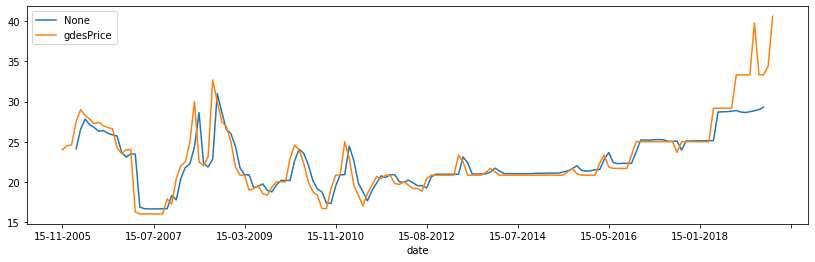

In [ ]:
pred_final.plot(legend='Price of local rice')
final.gdesPrice.plot(figsize=(14,4), legend='Prediction of price of rice')


In [ ]:
final.head()

commodity  gdesPrice  Taux de change
date                                           
15-11-2005     Rice        24.0       40.450001
15-12-2005     Rice        24.5       40.491001
15-01-2006     Rice        24.6       41.945000
15-02-2006     Rice        27.5       40.206001
15-03-2006     Rice        29.0       39.998001

In [ ]:
# res.plot_predict(start=140, end=156,exog=exog)

In [ ]:
dir(res)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_ar_lags',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_df_model',
 '_get_robustcov_results',
 '_hold_back',
 '_lag_repr',
 '_max_lag',
 '_n_totobs',
 '_nobs',
 '_params',
 '_plot_predictions',
 '_use_t',
 'aic',
 'aicc',
 'ar_lags',
 'arfreq',
 'bic',
 'bse',
 'conf_int',
 'cov_params',
 'cov_params_default',
 'data',
 'df_model',
 'df_resid',
 'diagnostic_summary',
 'f_test',
 'fittedvalues',
 'forecast',
 'fpe',
 'get_prediction',
 'hqic',
 'initialize',
 'llf',
 'load',
 'model',
 'nobs',
 'normalized_cov_params',
 'params',
 'plot_diagnostics',
 'plot_predict',
 'predict',
 'pvalues',
 'remove_data',
 'resid',
 '

In [ ]:
res.params

const                2.037668
gdesPrice.L1         0.850180
Taux de change.L0    0.028832
dtype: float64

In [ ]:
# prix=f(prix)